<a href="https://colab.research.google.com/github/Awaish0419/MultiPeriodBinomialTreePricing/blob/main/MultiPeriodBinomialTreePricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binomial Tree Option Class

In [ ]:
import numpy as np

class BinomialTreeOption:
  def __init__(self, S0, r, T, sigma, N, K, option_type="call"):
    self.S0 = S0  # Spot price
    self.r = r  # Risk-free rate
    self.T = T  # Maturity
    self.sigma = sigma  # Volatility
    self.N = N  # Number of steps
    self.K = K  # Strike price
    self.option_type = option_type.lower()  # 'call' or 'put'
    self.dt = T / N  # Time step
    self.u = np.exp(sigma * np.sqrt(self.dt))  # Up factor
    self.d = 1 / self.u  # Down factor
    self.p = (np.exp(r * self.dt) - self.d) / (self.u - self.d)  # Risk-neutral probability

  def generate_price_tree(self):
    tree = np.zeros((self.N + 1, self.N + 1))
    tree[0, 0] = self.S0
    for i in range(1, self.N + 1):
      tree[0, i] = tree[0, i - 1] * self.u
      for j in range(1, i + 1):
        tree[j, i] = tree[j - 1, i - 1] * self.d
    return tree

  def price_option(self):
    # Generate the price tree
    tree = self.generate_price_tree()

    # Initialize option value at maturity
    option_values = np.zeros(self.N + 1)
    if self.option_type == "call":
      option_values = np.maximum(0, tree[:, self.N] - self.K)
    elif self.option_type == "put":
      option_values = np.maximum(0, self.K - tree[:, self.N])

    # Backward induction to calculate option price
    for i in range(self.N - 1, -1, -1):
      for j in range(i + 1):
        option_values[j] = np.exp(-self.r * self.dt) * (self.p * option_values[j] + (1 - self.p) * option_values[j + 1])

    return option_values[0]

  def price_options(self, spot_prices):
    option_values = []
    initial_S0 = self.S0
    for price in spot_prices:
      self.S0 = price
      option_values.append(self.price_option())
    self.S0 = initial_S0
    return option_values

  def change_type(self):
    if (self.option_type == "call"):
      self.option_type = "put"
    else:
      self.option_type = "call"

  def plot_option_price_vs_spot(self, spot_prices):
    import matplotlib.pyplot as plt
    prices = []
    for S in spot_prices:
      self.S0 = S
      prices.append(self.price_option())

    plt.plot(spot_prices, prices, label=f"{self.option_type.capitalize()} Option Price")

    self.change_type()
    prices = []
    for S in spot_prices:
      self.S0 = S
      prices.append(self.price_option())

    plt.plot(spot_prices, prices, label=f"{self.option_type.capitalize()} Option Price")

    plt.xlabel("Spot Price")
    plt.ylabel("Option Price")
    plt.title(f"{self.option_type.capitalize()} Option Price vs Spot Price")
    plt.legend()

  def plot_delta_vs_spot(self, spot_prices, dS=1e-4):
    import matplotlib.pyplot as plt
    deltas = []
    for S in spot_prices:
      # Calculate option price for S and S + dS
      self.S0 = S
      price_1 = self.price_option()
      self.S0 = S + dS
      price_2 = self.price_option()

      # Estimate Delta using finite difference
      delta = (price_2 - price_1) / dS
      deltas.append(delta)

    plt.plot(spot_prices, deltas, label=f"{self.option_type.capitalize()} Option Delta")

    self.change_type()

    deltas = []
    for S in spot_prices:
      # Calculate option price for S and S + dS
      self.S0 = S
      price_1 = self.price_option()
      self.S0 = S + dS
      price_2 = self.price_option()

      # Estimate Delta using finite difference
      delta = (price_2 - price_1) / dS
      deltas.append(delta)

    plt.plot(spot_prices, deltas, label=f"{self.option_type.capitalize()} Option Delta")

    plt.xlabel("Spot Price")
    plt.ylabel("Delta (∂V/∂S)")
    plt.title(f"{self.option_type.capitalize()} Option Delta vs Spot Price")
    plt.legend()
    plt.show()

  def print_delta_beta_tree(self):
    stock_tree = self.generate_price_tree()
    option_tree = np.zeros((self.N + 1, self.N + 1))
    for i in range(self.N + 1):
      if (self.option_type == "call"):
        option_tree[i, self.N] = np.maximum(0, stock_tree[i, self.N] - self.K)
      else:
        option_tree[i, self.N] = np.maximum(0, self.K - stock_tree[i, self.N])
    delta_tree = np.zeros((self.N, self.N))
    beta_tree = np.zeros((self.N, self.N))
    for i in range(self.N - 1, -1, -1):
      for j in range(i + 1):
        option_tree[j, i] = (self.p * option_tree[j, i + 1] + (1 - self.p) * option_tree[j + 1, i + 1]) / np.exp(self.r * self.dt)
        delta_tree[j, i] = (option_tree[j, i + 1] - option_tree[j + 1, i + 1]) / (stock_tree[j + 1, i] - stock_tree[j + 1, i + 1])
        beta_tree[j, i] = (option_tree[j, i] - delta_tree[j, i] * stock_tree[j, i]) / np.exp(self.r * self.dt)

    print(f"{self.option_type} Delta tree:")
    print(delta_tree)

    print(f"{self.option_type} Beta tree:")
    print(beta_tree)

  def print_both_delta_beta_tree(self):
    self.print_delta_beta_tree()
    self.change_type()
    self.print_delta_beta_tree()

  def combination(self, N, i):
    if i == 0 or i == N:
      return 1
    result = 1
    for k in range(1, i + 1):
      result = result * (N - k + 1) // k
    return result

  def plot_ST_distribution(self):
    import matplotlib.pyplot as plt
    final_prices = []
    probabilities = []
    for i in range(self.N + 1):
      ST = S0 * (self.u ** i) * (self.d ** (self.N - i))
      P = self.combination(self.N, i) * (self.p ** i) * ((1 - self.p) ** (self.N - i))
      final_prices.append(ST)
      probabilities.append(P)
    plt.plot(final_prices, probabilities)
    plt.title("Probability Distribution of S(T) from Binomial Tree")
    plt.xlabel("S(T)")
    plt.ylabel("Probability")
    plt.grid(True)
    plt.show()

  def plot_log_ST_distribution(self):
    import matplotlib.pyplot as plt
    final_prices = []
    probabilities = []
    for i in range(self.N + 1):
      ST = S0 * (self.u ** i) * (self.d ** (self.N - i))

      P = self.combination(self.N, i) * (self.p ** i) * ((1 - self.p) ** (self.N - i))
      final_prices.append(np.log(ST))
      probabilities.append(P)
    plt.plot(final_prices, probabilities)
    plt.title("Probability Distribution of log(S(T)) from Binomial Tree")
    plt.xlabel("log(S(T))")
    plt.ylabel("Probability")
    plt.grid(True)
    plt.show()


# Initial parameters

In [ ]:
S0 = 100
r = 0.02
T = 1.5
sigma = 0.2
N = 6
K = 102
option_type = "call"
BTO = BinomialTreeOption(S0, r, T, sigma, N, K, option_type)

# Plot the price function V (S) with different values of spot price, for both call and puts, what you observe?

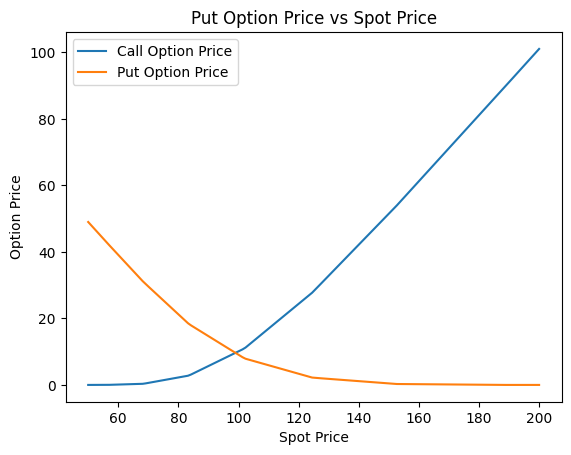

In [ ]:
import matplotlib.pyplot as plt

spot_prices = np.linspace(50, 200, 150)

BTO.plot_option_price_vs_spot(spot_prices)

# reset
BTO = BinomialTreeOption(S0, r, T, sigma, N, K, option_type)

According to the plots of prices of call options and put options, we can see that the call option value increases as the spot price increases, and the put option value decreases as the spot price increases. Additionally, the option price can never drop below 0.

# Plot the price function V (S) with different values of spot price, for both call and puts, what you observe?

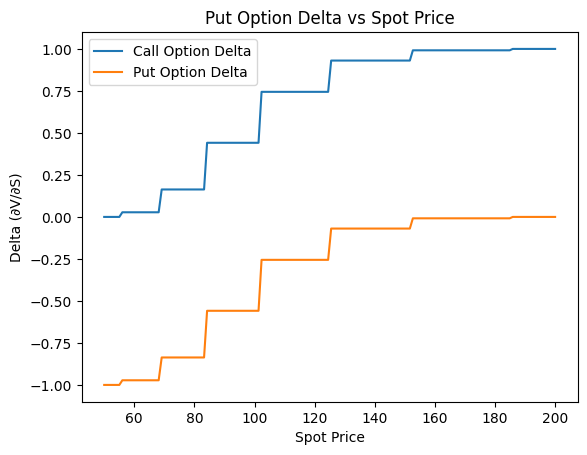

In [ ]:
BTO.plot_delta_vs_spot(spot_prices)

# reset
BTO = BinomialTreeOption(S0, r, T, sigma, N, K, option_type)

# Can you obtain the replication portfolio for each node? (i.e. given a tree node, what is your ∆ and β)?

In [ ]:
BTO.print_both_delta_beta_tree()

# reset
BTO = BinomialTreeOption(S0, r, T, sigma, N, K, option_type)

call Delta tree:
[[-0.12453184 -1.68710998 -2.04414339 -2.28399134 -2.32657368 -2.32657368]
 [ 0.         -0.08053214 -1.25095564 -1.75114359 -2.23197248 -2.32657368]
 [ 0.          0.         -0.03348559 -0.6399228  -1.16375991 -2.11640704]
 [ 0.          0.          0.         -0.         -0.         -0.        ]
 [ 0.          0.          0.          0.         -0.         -0.        ]
 [ 0.          0.          0.          0.          0.         -0.        ]]
call Beta tree:
[[ 22.43330641 201.22259823 272.19051868 341.34625637 393.30991965
  444.73874275]
 [  0.          11.73665479 132.26027408 205.75219524 292.79622182
  345.81579582]
 [  0.           0.           3.95599258  60.08212039 120.75649679
  242.70334371]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]]
put Delta tree:
[[ 0.09687092  0.6394637 

# At your final time state T = Tn, plot the distribution of S(T), can you identify it? (Hint: you can look at
 distribution of log(S(T)))

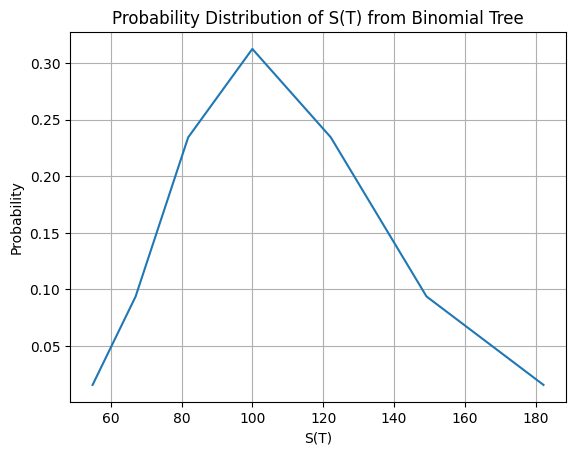

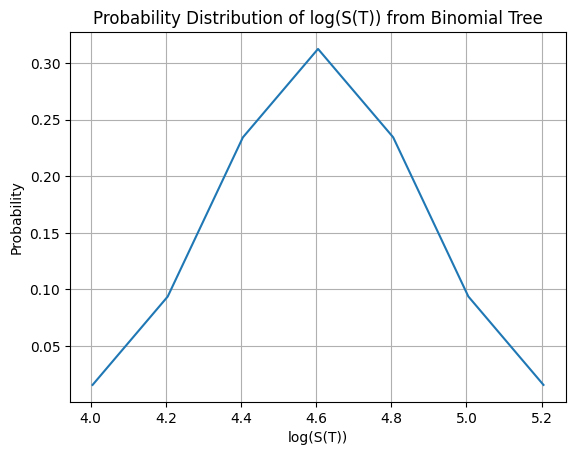

In [ ]:
BTO.plot_ST_distribution()
BTO.plot_log_ST_distribution()

According to the plots, I can see that the distribution of S(T) follows a bias gausian distribution, and the log(S(T)) follows a gausian distribution.

# Can you modify your code so that it can price an american option?

In [ ]:
class BinomialTreeAmericanOption:
  def __init__(self, S0, r, T, sigma, N, K, option_type="call"):
    self.S0 = S0  # Spot price
    self.r = r  # Risk-free rate
    self.T = T  # Maturity
    self.sigma = sigma  # Volatility
    self.N = N  # Number of steps
    self.K = K  # Strike price
    self.option_type = option_type.lower()  # 'call' or 'put'
    self.dt = T / N  # Time step
    self.u = np.exp(sigma * np.sqrt(self.dt))  # Up factor
    self.d = 1 / self.u  # Down factor
    self.p = (np.exp(r * self.dt) - self.d) / (self.u - self.d)  # Risk-neutral probability

  def generate_price_tree(self):
    tree = np.zeros((self.N + 1, self.N + 1))
    tree[0, 0] = self.S0
    for i in range(1, self.N + 1):
      tree[0, i] = tree[0, i - 1] * self.u
      for j in range(1, i + 1):
        tree[j, i] = tree[j - 1, i - 1] * self.d
    return tree

  def price_option(self):
    # Generate the price tree
    tree = self.generate_price_tree()

    # Initialize option value at maturity
    option_values = np.zeros(self.N + 1)
    if self.option_type == "call":
      option_values = np.maximum(0, tree[:, self.N] - self.K)
    elif self.option_type == "put":
      option_values = np.maximum(0, self.K - tree[:, self.N])

    # Backward induction to calculate option price
    for i in range(self.N - 1, -1, -1):
      for j in range(i + 1):
        option_value = np.exp(-self.r * self.dt) * (self.p * option_values[j] + (1 - self.p) * option_values[j + 1])
        if option_value > (tree[j, i] - self.K):
          option_values[j] = option_value
        else:
          option_values[j] = tree[j, i] - self.K

    return option_values[0]